# Lab 7: k-Means Clustering

In this lab, we will write our own function to perform k-means clustering. 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd

## Introducing k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

In [ ]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## k-Means Algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
   1. *E-Step*: assign points to the nearest cluster center
   2. *M-Step*: set the cluster centers to the mean 

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

The algorithm terminates when the newly computed cluster centers no longer move. 

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.

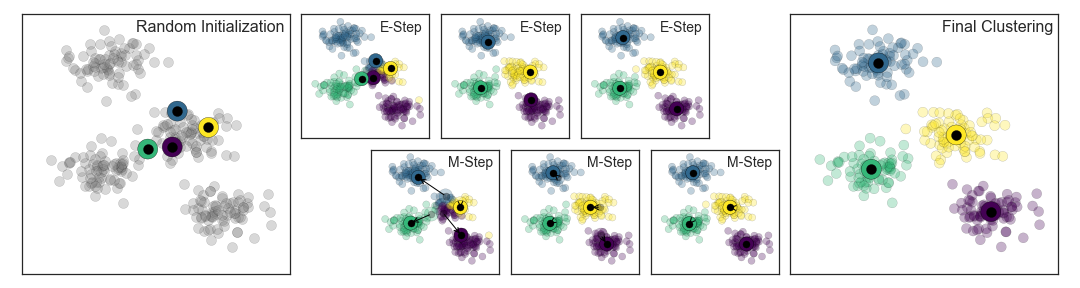

We will now write our own code to do k-means clustering.

**Question 1**: To start the k-means algorithm, you must choose *k* initial cluster centers. These centers are typically chosen to be *k* random observations from your data. Finish the following function to choose *k* random rows of *X*.

In [ ]:
def initialize_centers(X, k):
    ...
    return centers

<details><summary><button>Click here to reveal the answer!</button></summary>
<pre>
def initialize_centers(X, k):
    ix = np.random.choice(np.arange(X.shape[0]), k)
    centers = X[ix]
    return centers
    </pre>
</details>

Now, we need to assign cluster labels to the data by finding the center each datapoint is closest to. We can use the `pairwise_distances` function from `sklearn` to compute distance betwen each row of *X* and each of the *k* centers. This function takes the data, *X*, and the centers, and returns an *n* by *k* matrix where each row corresponds to a row of *X* and each column corresponds to each of the *k* cluster centers.

**Question 2**: Complete the `label_clusters` function which first computes the pairwise distances between the data and the centers, and then returns an *n* length list indicating which of the *k* clusters each datapoint is closest to. *Hint: np.argmin will be helpful here*

In [ ]:
from sklearn.metrics import pairwise_distances

def label_clusters(X, centers, k):
    distances = pairwise_distances(X, centers)
    labels = ...
    return labels

<details><summary><button>Click here to reveal the answer!</button></summary>
<pre>
def label_clusters(X, centers, k):
    distances = pairwise_distances(X, centers)
    labels = np.argmin(distances, axis=1)
    return labels
    </pre>
</details>



Next, we need to recompute the cluster centers as the "center" or mean value of the new clusters. For example, if we had a cluster containing the points [(1,1), (2,2), (1,2), (2,1)], the center of that cluster would be [1.5, 1.5].

**Question 3:** Write a function to compute cluster centers. They should be returned as an array. To do this, you'll need to somehow connect the data and the labels - there are many ways to do this, but pandas might be useful!

In [ ]:
def cluster_centers(X, labels):
    ...
    return centers

<details><summary><button>Click here to reveal the answer!</button></summary>
<pre>
def cluster_centers(X, labels):
    df = pd.DataFrame(X)
    df['labels'] = labels
    centers = df.groupby('labels').mean().values
    return centers
    </pre>
</details>



Great! Time to put it all together. The final function you write will perform the full k-means algorithm, from initialization to stopping conditions.

**Question 4**: Finish the function `find_clusters` by specifying the stopping condition under comment 4. Recall that the algorithm terminates when the cluster centers stop moving.

In [ ]:
def find_clusters(X, k):
    # 1. Initialize cluster centers
    centers = initialize_centers(X,k)
    
    while True:
        # 2. Label the clusters
        labels = label_clusters(X,centers)
        
        # 3. Find new centers
        new_centers = cluster_centers(X, labels)
        
        # 4. Check if algorithm has converged
        if ...:
            break
        centers = new_centers
    
    return centers, labels

<details><summary><button>Click here to reveal the answer!</button></summary>
<pre>
if np.all(clusters == new_clusters):
    </pre>
</details>



Finally, we can test our function and see what happens! Try running the following cell multiple times. What do you notice?

In [ ]:
centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution. Whether or not it converges to the globally optimal solution is based on the choice of center intitialization. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

In [ ]:
centers, labels = find_clusters(X, 6)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

**How to we choose the right number of clusters?** 

One way to determine if you've chosen the right number of clusters if it is not immediately obvious is to create what's known as an *elbow plot*. We are interested in choosing the smallest number of clusters such that the variance of the data within clusters is minimized. Usually, we find that there is a steep drop-off in the variance and then it plateaus - we are looking for the value at which the steep drop-off occurs. See the lecture notes for more details.

**Question 5**: Create an elbow plot using your k-means algorithm. Look at values of *k* from 1 to 10 and see if there is an obvious value to choose for *k*. You might want to run your code a few times and see how changing the initialization influences the elbow plot. You can use the following code to compute the approximate intra-cluster variance:

`np.mean([np.linalg.norm(X[labels == i] - centers[i]) for i in range(k)])`

In [ ]:
...

<details><summary><button>Click here to reveal the answer!</button></summary>
<pre>
errors = []
for k in np.arange(1,11):
    centers, labels = find_clusters(X, k)
    error = np.mean([np.linalg.norm(X[labels == i] - centers[i]) for i in range(k)])
    errors.append(error)
    
plt.plot(errors)
    </pre>
</details>

Done! Thanks to https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html for providing materials for this lab.
